# Peter and the Wolf: Reinforcement Learning Primer

In this tutorial, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) musical fairy tale by Russian composer [Segei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase the wolf. We will train machine learning algorithms that will help Peter to explore the surroinding area and build an optimal navigation map.

First, let's import a bunch of userful libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Overview of Reinforcement Learning

**Reinforcement Learning** (RL) is a learning technique that allows us to learn an optimal behaviour of an **agent** in some **environment** by running many experiments. An agent in this environment should have some **goal**, defined by a **reward function**.

## The Environment

For simplicity, let's consider Peter's world to be a square board of size `width` x `height`. Each cell in this board can either be:
* **ground**, on which Peter and other creatures can walk
* **water**, on which you obviously cannot walk
* **a tree** or **grass** - a place where you cat take some rest
* **an apple**, which represents something Peter would be glad to find in order to feed himself
* **a wolf**, which is dangerous and should be avoided

To work with the environment, we will define a class called `Board`. In order not to clutter this notebook too much, we have moved all code to work with the board into separate `rlboard` module, which we will now import. You may look inside this module to get more details about the internals of the implementation.

In [2]:
from rlboard import *

Let's now create a random board and see how it looks:

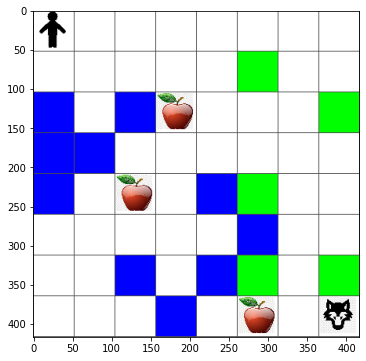

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Actions and Policy

In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. To do this, he can essentially walk around until he finds and apple. Therefore, at any position he can chose between one of the following actions: up, down, left and right. We will define those actions as a dictionary, and map them to pairs of corresponding coordinate changes. For example, moving right (`R`) would correspond to a pair `(1,0)`.

In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

The strategy of our agent (Peter) is defined by so-called **policy**. A policy is a function that returns the action at any given state. In our case, the state of the problem is represented by the board, including the current position of the player. 

The goal of reinforcement learning is to eventually learn a good policy that will allow us to solve the problem efficiently. However, as a baseline, let's consider the simplest policy called **random walk**.

## Random walk

Let's first solve our problem by implementing a random walk strategy. With random walk, we will randomly chose the next action from allowed ones, until we reach the apple. 

In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Let's run random walk experiment several times and see the average number of steps taken:

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Reward Function

To make out policy more intelligent, we need to understand which moves are "better" than others. To do this, we need to define our goal. The goal can be defined in terms of **reward function**, that will return some score value for each state. The higher the number - the better is the reward function



In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

Interesting thing about reward function is that in most of the cases *we are only given substantial reward at the end of the game*. It means that out algorithm should somehow remember "good" steps that lead to positive reward at the end, and increase their importance. Similarly, all moves that lead to bad results should be discouraged.

## Q-Learning

An algorithm that we will discuss here is called **Q-Learning**. In this algorithm, the policy is defined by a function (or a data structure) called **Q-Table**. It records the "goodness" of each of the actions in a given state, i.e. $Q : {S\times A}\to\mathbb{R}$, where $S$ is a set of states, $A$ is the set of actions.

It is called Q-Table because it is often convenient to represent it as a table, or multi-dimensional array. Since our board has dimentions `width` x `height`, we can represent Q-Table by a numpy array with shape `width` x `height` x `len(actions)`:

In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Notice that we initially initialize all values of Q-Table with equal value, in our case - 0.25. That corresponds to the "random walk" policy, because all moves in each state are equally good. We can pass the Q-Table to the `plot` function in order to visualize the table on the board:

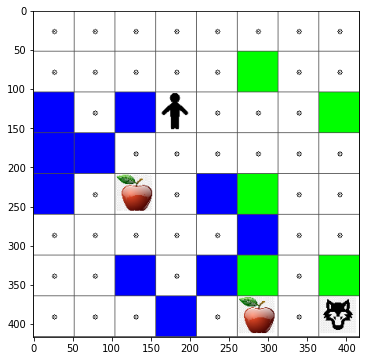

In [9]:
m.plot(Q)

In the center of each cell there is an "arrow" that indicates the preferred direction of movement. Since all directions are equal, a dot is displayed.

Now we need to run the simulation, explore our environment, and learn better distribution of Q-Table values, which will allow us to find the path to the apple much faster.

## Essence of Q-Learning: Bellman Equation

Once we start moving, each action will have a corresponding reward, i.e. we can theoretically select the next action based on the highest immediate reward. However, in most of the states the move will not achieve our goal or reaching the apple, and thus we cannot immediately decide which direction is better.

> It is not the immediate result that matters, but rather the final result, which we will obtain at the end of the simulation.

In order to account for this delayed reward, we need to use the principles of **[dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming)**, which allows us to think about out problem recursively.

Suppose we are now at the state $s$, and we want to move to the next state $s'$. By doing so, we will receive the immediate reward $r(s,a)$, defined by reward function, plus some future reward. If we suppose that our Q-Table correctly reflects the "attractiveness" of each action, then at state $s'$ we will chose an action $a'$ that corresponds to maximum value of $Q(s',a')$. Thus, the best possible future reward we could get at state $s'$ will be defined as $\max_{a'}Q(s',a')$ (maximum here is computed over all possible actions $a'$ at state $s'$). 

This gives the **Bellman formula** for calculating the value of Q-Table at state $s$, given action $a$:

$$Q(s,a) = r(s,a) + \gamma \max_{a'} Q(s',a')$$

Here $\gamma$ is so-called **discount factor** that determines to which extent you should prefer current reward over the future reward and vice versa.

## Learning Algorithm

Given the equation above, we can now write a pseudo-code for our leaning algorithm:

* Initialize Q-Table Q with equal numbers for all states and actions
* Set learning rate $\alpha\leftarrow 1$
* Repeat simulation many times
   1. Start at random position
   1. Repeat
        1. Select an action $a$ at state $s$
        2. Exectute action by moving to a new state $s'$
        3. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        4. Compute reward $r$ at the new state
        5. Update Q-Function according to Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Update total reward and decrease $\alpha$.

## Exploit vs. Explore

In the algorithm above, we did not specify how exactly we should chose an action at step 2.1. If we are choosing the action randomly, we will randomly **explore** the environment, and we are quite likely to die often, and also explore such areas where we would not normally go. An alternative approach would be to **exploit** the Q-Table values that we already know, and thus to chose the best action (with highers Q-Table value) at state $s$. This, however, will prevent us from exploring other states, and quite likely we might not find the optimal solution.

Thus, the best approach is to balance between exploration and exploitation. This can be easily done by choosing the action at state $s$ with probabilities proportional to values in Q-Table. In the beginning, when Q-Table values are all the same, it would correspond to random selection, but as we learn more about our environment, we would be more likely to follow the optimal route, however, choosing the unexplored path once in a while.

## Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add small amount `eps` to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

The actual learning algorithm we will run for 5000 experiments, also called **epochs**: 

In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos)
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Epoch = 2

IndexError: index 8 is out of bounds for axis 0 with size 8

After executing this algorithm, Q-Table should be updated with values that define the attractiveness of different actions at each step. We can try to visualize Q-Table by plotting a vector at each cell that will point in the desired direction of movement. For simplicity, we draw small circle instead of arrow head.

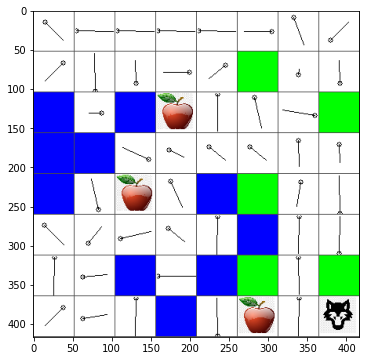

In [43]:
m.plot(Q)

## Checking the Policy

Since Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can just select the action corresponding to the highest Q-Table value:

In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

If you try the code above several times, you may notice that sometimes it just "hangs", and you need to press STOP button in the notebook to interrupt it. This happens because there could be situations when two states "point" to each other in terms of optimal Q-Value, in which case the agents ends up moving between those states indefinitely.

> **Task 1:** Modify the `walk` function to limit the maximum length of path by a certain number of steps (say, 100), and watch the code above return this value from time to time.

> **Task 2:** Modify the `walk` function so that it does not go back to the places where is has already been previously. This will prevent `walk` from looping, however, the agent can still end up being "trapped" in a location from which it is unable to escape.

Better navigation policy would be the one that we have used during training, which combines exploitation and exploration. In this policy, we will select each action with a certain probability, proportional to the values in Q-Table. This strategy may still result in the agent returning back to the position it has already explored, but, as you can see from the code below, it results in very short average path to the desired location (remember that `print_statistics` runs the simulation 100 times):  

In [58]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 5.31, eaten by wolf: 0 times


## Investigating Learning Process

As we have mentioned, the learning process is a balance between exploration and exploration of gained knowledge about the structure of problem space. We have seen that the result of learning (the ability to help an agent to find short path to the goal) has improved, but it is also interesting to observe how the average path length behaves during the learning process: 

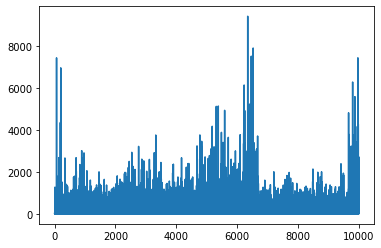

In [57]:
plt.plot(lpath)

What we see here is that at first the average path length increased. This is probably due to the fact that when we know nothing about the environment - we are likely to get trapped into bad states, water or wolf. As we learn more and start using this knowledge, we can explore the environment for longer, but we still do not know well where apples are.

Once we learn enough, it becomes easier for the agent to achieve the goal, and the path length starts to decrease. However, we are still open to exploration, so we often diverge away from the best path, and explore new options, making the path longer than optimal.

What we also observe on this graph, is that at some point the length increased abruptly. This indicates stochastic nature of the process, and that we can at some point "sploil" the Q-Table coefficients, by overwriting them with new values. This ideally should be minimized by decreasing learning rate (i.e. towards the end of training we only adjust Q-Table values by a small value).

Overall, it is important to remember that the success and quality of the learning process significantly depends on parameters, such as leaning rate, learning rate decay and discount factor. Those are often called **hyperparameters**, to distinguish them from **parameters** which we optimize during training (eg. Q-Table coefficients). The process of finding best hyperparameter values is called **hyperparameter optimization**, and it deserves a separate topic.

## Exercise
#### More Realistic Peter and the Wolf World

In our situation, Peter was able to move around almost without getting tired or hungry. In more realistic world, we has to sit down and rest from time to time, and also to feed himself. Let's make our world more realistic, by implementing the following rules:

1. By moving from one place to another, Peter loses **energy** and gains some **fatigue**.
2. Peter can gain more energy by eating apples.
3. Peter can get rid of fatigue by resting under the tree or on the grass (i.e. walking into a board location with a tree or grass - green field)
4. Peter needs to find and kill the wolf
5. In order to kill the wolf, Peter needs to have certain levels of energy and fatigue, otherwise he loses the battle.

Modify the reward function above according to the rules of the game, run the reinforcement learning algorithm to learn the best strategy for winning the game, and compare the results of random walk with your algorithm in terms of number of games won and lost.


> **Note**: You may need to adjust hyperparameters to make it work, especially the number of epochs. Because the success of the game (fighting the wolf) is a rare event, you can expect much longer training time.

